In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from time import time

%matplotlib inline

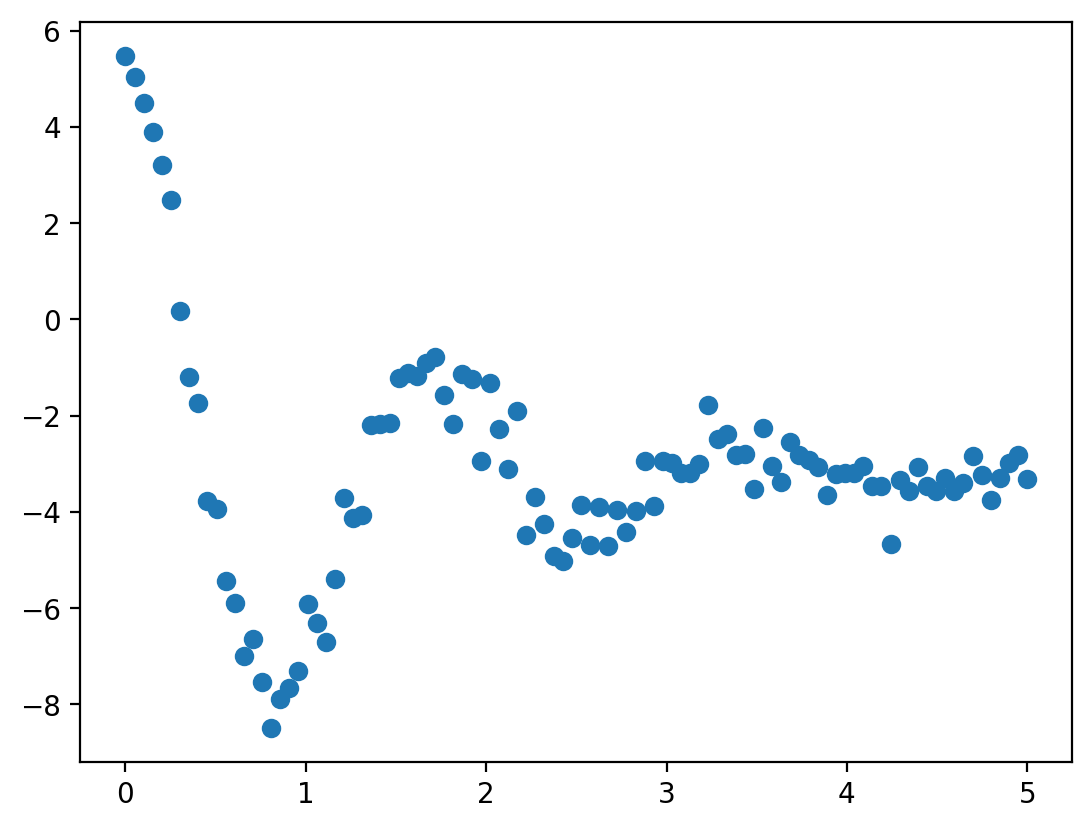

In [2]:
from scipy.integrate import solve_ivp

def func(t, xy, m, gamma, k):
    xp = xy[1]
    yp = -10*m - gamma * xy[1] - k * xy[0]
    return np.array([xp, yp])

def integrate(u0, beta, t0=0, tf=5, eval_points=100, sigma=0.5):
    m, gamma, k = beta
    fun = lambda t, xy: func(t, xy, m, gamma, k)

    xy0 = np.array([u0, 0])

    t_eval = np.linspace(t0, tf, eval_points)
    result = solve_ivp(fun, (t0, tf), xy0, t_eval=t_eval)
    t, u = result.t, result.y[0]
    u += np.random.normal(0, sigma, size=u.shape)
    return t, u

u0 = 5
beta_true = [5, 1.5, 15]
t, u_true = integrate(u0, beta_true)

fig, ax = plt.subplots(1,1, dpi=200)
ax.scatter(t, u_true)

In [3]:
from tqdm import tqdm
from numba import jit

def gaussian_proposal(beta, randn, scale=0.05):
    # Gaussian proposal distribution centered at current beta
    return randn * scale + beta

def log_laplace_prior(beta):
    # Laplace prior on parameter values
    return -np.abs(beta) - np.log(2)

def log_gaussian_likelihood(y0, u_true, beta, sigma=0.5):
    # Gaussian likelihood assuming measurement noise sigma
    _, u_pred = integrate(u0, beta[0])
    return -(u_true - u_pred)**2 / (2 * sigma**2) - 0.5 * np.log(2 * np.pi * sigma**2)

def posterior_probability(u0, u_true, beta, 
                          log_likelihood_func=log_gaussian_likelihood, 
                          log_prior_func=log_laplace_prior, 
                          sigma=0.5):
    # Return the un-normalized log posterior
    log_likelihood = np.sum(log_likelihood_func(u0, u_true, beta, sigma=sigma))
    log_prior = np.sum(log_prior_func(beta))
    return log_likelihood + log_prior

def metropolis_hastings(num_iter, burn_in, proposal_distribution, posterior_distribution):
    randu = np.random.random(size=num_iter+burn_in)
    randn = np.random.normal(size=(num_iter+burn_in, 3))
    betas = np.empty(shape=(num_iter+burn_in, 3), dtype=np.float64)
    beta_curr = np.empty((1,3), dtype=np.float64)
    for i in range(3):
        beta_curr[0,i] = np.random.normal()

    for i in range(num_iter+burn_in):
        beta_new = proposal_distribution(beta_curr, randn[i])
        prob_curr = posterior_distribution(u0, u_true, beta_curr)
        prob_new = posterior_probability(u0, u_true, beta_new)

        if prob_new > prob_curr:
            acceptance_ratio = 1.
        else:
            acceptance_ratio = np.exp(prob_new - prob_curr)
        acceptance_probability = min(1, acceptance_ratio)
        if randu[i] < acceptance_probability:
            beta_curr = beta_new
        
        betas[i] = beta_curr[0]
    
    return betas[burn_in:]

import multiprocessing as mp
def parallel_mh(num_chains, num_iter, burn_in, proposal_distribution, posterior_distribution):
    print(f'Running MH in parallel with {num_chains} chains')
    with mp.Pool(processes=num_chains) as pool:
        results = pool.starmap(
            metropolis_hastings,
            [(num_iter, burn_in, proposal_distribution, posterior_distribution) for _ in range(num_chains)]
        )
    return np.concatenate(results, axis=0)

num_iter, burn_in = 20000, 1000
t = time()
betas = parallel_mh(2, num_iter, burn_in, gaussian_proposal, posterior_probability)

print(f'Finished {num_iter} training steps in {time()-t:.3g} s')


Running MH in parallel with 2 chains
Finished 20000 training steps in 254 s


/home/jcolen/envs/default-pytorch-gpu-2.1.0/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jcolen/envs/default-pytorch-gpu-2.1.0/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


/home/jcolen/envs/default-pytorch-gpu-2.1.0/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


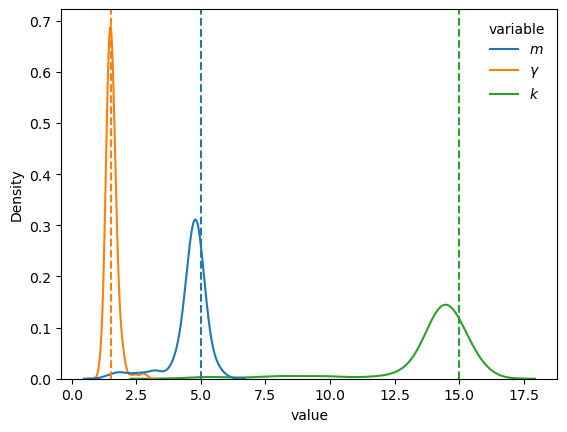

In [4]:
df = pd.DataFrame(
    data=np.array(betas).squeeze(),
    columns=['$m$', '$\gamma$', '$k$']
)
df['step'] = df.index
df = df.melt(id_vars=['step'])

fig, ax = plt.subplots(1, 1, dpi=100)
plt.rcParams['legend.framealpha'] = 0.
sns.kdeplot(
    data=df,
    bw_adjust=2.5,
    multiple='layer',
    x='value',
    hue='variable',
    ax=ax,
)

ax.axvline(beta_true[0], color='tab:blue', linestyle='--')
ax.axvline(beta_true[1], color='tab:orange', linestyle='--')
ax.axvline(beta_true[2], color='tab:green', linestyle='--')